In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
import math

import re
import time
from datetime import datetime

import catboost as cb
import lightgbm as lgb
import xgboost as xgb

from hyperopt import fmin, hp, tpe, Trials, STATUS_OK

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
crime = pd.read_csv("data/crimedata_cleaned.csv")

In [323]:
crime_df = crime

In [324]:
crime.head()

,incident_number,offense_code,crime_type,occurred_date_time,occurred_date,address,zip_code,location_type,x_coordinate,y_coordinate,longitude,latitude,council_district,month,year,week,dayofmonth,monthnum
0,20228022672,601,Burglary Of Vehicle,2022-12-01 11:30:00,2022-12-01,1921 Willow Creek Dr,78741,Residence / Home,3119469,10058001,-97.727425,30.232680,3,December,2022,Thursday,1,12
1,20225033150,504,Burglary Of Shed/Detached Garage/Storage Unit,2022-11-07 20:00:00,2022-11-07,4113 Avenue F,78751,Parking /Drop Lot/ Garage,3118205,10084145,-97.729489,30.304627,9,November,2022,Monday,7,11
2,20228022553,619,Theft Of Metal,2022-12-01 23:27:00,2022-12-01,300 W 6Th St,78701,Commercial / Office Building,3113404,10071112,-97.745659,30.269110,9,December,2022,Thursday,1,12
3,20228022692,2405,Doc Unreasonable Noise,2022-12-03 05:00:00,2022-12-03,11704 N Lamar Blvd,78758,Residence / Home,3131678,10114301,-97.684531,30.386647,7,December,2022,Saturday,3,12
4,20225031961,600,Theft,2022-10-29 23:00:00,2022-10-29,708 E 6Th St,78701,Residence / Home,3116608,10070123,-97.735585,30.266186,9,October,2022,Saturday,29,10


In [325]:
crime_df['offense_code'] = crime_df['offense_code'].astype('int16')
crime_df['zip_code'] = crime_df['zip_code'].astype('int32')
crime_df['x_coordinate'] = crime_df['x_coordinate'].astype('int32')
crime_df['y_coordinate'] = crime_df['y_coordinate'].astype('int32')
crime_df['longitude'] = crime_df['longitude'].astype('float32')
crime_df['latitude'] = crime_df['latitude'].astype('float32')
crime_df['council_district'] = crime_df['council_district'].astype('int8')
crime_df['year'] = crime_df['year'].astype('int16')
crime_df['dayofmonth'] = crime_df['dayofmonth'].astype('int8')
crime_df['monthnum'] = crime_df['monthnum'].astype('int8')
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2287541 entries, 0 to 2287540
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   incident_number     int64  
 1   offense_code        int16  
 2   crime_type          object 
 3   occurred_date_time  object 
 4   occurred_date       object 
 5   address             object 
 6   zip_code            int32  
 7   location_type       object 
 8   x_coordinate        int32  
 9   y_coordinate        int32  
 10  longitude           float32
 11  latitude            float32
 12  council_district    int8   
 13  month               object 
 14  year                int16  
 15  week                object 
 16  dayofmonth          int8   
 17  monthnum            int8   
dtypes: float32(2), int16(2), int32(3), int64(1), int8(3), object(7)
memory usage: 198.5+ MB


In [168]:
airbnb = pd.read_csv("data/airbnb_cleaned.csv")

In [169]:
airbnb.head()

,id,host_id,zip_code,neighborhood,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,rating,price,longitude,latitude,total_reviews,availability_365
0,32666944,23,78744,McKinney,Private room in home,Private room,2,1.0,1.0,2,4.77,98,-97.75119,30.17937,13,241
1,23629432,23,78744,McKinney,Private room in home,Private room,2,1.0,1.0,1,4.46,80,-97.75080,30.17879,13,265
2,39056933,23,78744,McKinney,Tent,Entire home/apt,2,1.0,1.0,1,4.94,40,-97.75093,30.18005,18,148
3,42625339,796,78725,Austins' Colony,Entire cottage,Entire home/apt,4,2.0,4.0,1,4.93,138,-97.57637,30.24147,0,125
4,17074156,2466,78702,East Downtown,Entire guesthouse,Entire home/apt,3,1.0,1.0,30,4.68,135,-97.71234,30.27651,31,80


In [170]:
bnb = airbnb.drop(['id','host_id'],axis=1)

In [171]:
filter = (bnb.property_type=='Room in hotel') | (bnb.room_type=='Hotel room') | (bnb.room_type=='Room in boutique hotel')
bnb = bnb[~filter]

In [172]:
bnb.drop(bnb[bnb["price"]==bnb.price.max()].index,inplace=True)

In [173]:
bnb['zip_code'] = bnb['zip_code'].astype('int32')
bnb['accommodates'] = bnb['accommodates'].astype('int8')
bnb['bedrooms'] = bnb['bedrooms'].astype('int8')
bnb['beds'] = bnb['beds'].astype('int8')
bnb['minimum_nights'] = bnb['minimum_nights'].astype('int16')
bnb['rating'] = bnb['rating'].astype('float16')
bnb['price'] = bnb['price'].astype('int16')
bnb['longitude'] = bnb['longitude'].astype('float32')
bnb['latitude'] = bnb['latitude'].astype('float32')
bnb['availability_365'] = bnb['availability_365'].astype('int16')
bnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13948 entries, 0 to 13979
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   zip_code          13948 non-null  int32  
 1   neighborhood      13948 non-null  object 
 2   property_type     13948 non-null  object 
 3   room_type         13948 non-null  object 
 4   accommodates      13948 non-null  int8   
 5   bedrooms          13948 non-null  int8   
 6   beds              13948 non-null  int8   
 7   minimum_nights    13948 non-null  int16  
 8   rating            13948 non-null  float16
 9   price             13948 non-null  int16  
 10  longitude         13948 non-null  float32
 11  latitude          13948 non-null  float32
 12  total_reviews     13948 non-null  int64  
 13  availability_365  13948 non-null  int16  
dtypes: float16(1), float32(2), int16(3), int32(1), int64(1), int8(3), object(3)
memory usage: 858.1+ KB


In [174]:
bnb.to_csv('data/airbnb_formatted.csv',index=False)

In [326]:
crime_df.drop(['incident_number','month','week','address'],axis=1,inplace=True)

In [327]:
crime_df.head()

,offense_code,crime_type,occurred_date_time,occurred_date,zip_code,location_type,x_coordinate,y_coordinate,longitude,latitude,council_district,year,dayofmonth,monthnum
0,601,Burglary Of Vehicle,2022-12-01 11:30:00,2022-12-01,78741,Residence / Home,3119469,10058001,-97.727425,30.232681,3,2022,1,12
1,504,Burglary Of Shed/Detached Garage/Storage Unit,2022-11-07 20:00:00,2022-11-07,78751,Parking /Drop Lot/ Garage,3118205,10084145,-97.729492,30.304626,9,2022,7,11
2,619,Theft Of Metal,2022-12-01 23:27:00,2022-12-01,78701,Commercial / Office Building,3113404,10071112,-97.745659,30.269110,9,2022,1,12
3,2405,Doc Unreasonable Noise,2022-12-03 05:00:00,2022-12-03,78758,Residence / Home,3131678,10114301,-97.684532,30.386646,7,2022,3,12
4,600,Theft,2022-10-29 23:00:00,2022-10-29,78701,Residence / Home,3116608,10070123,-97.735588,30.266186,9,2022,29,10


In [308]:
crime_filter = [
    'Burglary Of Vehicle',
 'Theft',
 'Family Disturbance',
 'Criminal Mischief',
 'Assault With Injury',
 'Burglary Of Residence',
 'DWI',
 'Harassment',
 'Disturbance - Other',
 'Criminal Trespass',
 'Theft By Shoplifting',
 'Auto Theft',
 'Assault By Contact',
 'Narcotic Possession',
 'Burglary Non Residence',
 'Possession of Drug',
 'Aggravated Assault',
 'Debit/Credit Card Abuse',
 'Identity Theft',
 'Theft Of Bicycle',
    'Violation City Ordinance'
 'Assault By Threat',
 'Terroristic Threat',
 'Aggravated Robbery',
 'Fraud - Other',
 'Dating Disturbance',
 'Theft From Auto',
 'Theft Of License Plate',
 'Theft From Person',
 'Theft Of Auto Parts',
 'Prostitution',
 'Unlawful Carrying Weapon',
 'Theft From Building',
 'Forgery - Other',
 'Theft Of Trailer',
 'Counterfeiting',
 'Theft Catalytic Converter',
 'Deadly Conduct','Violation City Ordinance','Driving While Intox / Felony','Assault On Public Servant','Robbery By Threat']

crime_df = crime_df[crime_df.crime_type.isin(crime_filter)]

In [309]:
location_filter = [
                   'Field / Woods',
                   'Jail / Prison/Penitentiary/Corrections Facility',
                   'Dock / Wharf / Freight / Modal Terminal',
                   'Shelter-Mission / Homeless',
                   'Cyberspace',
                   'Military Installation', 
                   'Tribal Lands',
                   'Farm Facility']
crime_df = crime_df[~crime_df.location_type.isin(location_filter)]

In [310]:
crime_df.shape

(1841531, 14)

In [328]:
crime_agg = crime_df.groupby(['zip_code','crime_type']).agg(Total_crimes=('crime_type','count')).reset_index()
crime_agg

,zip_code,crime_type,Total_crimes
0,78610,Assault With Injury,1
1,78610,Auto Theft,1
2,78610,Burglary Non Residence,1
3,78610,Burglary Of Residence,1
4,78610,Burglary Of Vehicle,1
...,...,...,...
9457,78759,Voco - Alcohol Consumption,44
9458,78759,Voco Amplified Music/Vehicle,20
9459,78759,Voco Solicitation Prohibit,208
9460,78759,Warrant Arrest Non Traffic,695


In [329]:
crime_agg.to_csv('data/crime_agg_all.csv',index=False)

In [39]:
bnb = pd.read_csv('data/airbnb_formatted.csv')

Merge the airbnb dataset with the crime dataset on the basis of zip code.

In [41]:
merged_df = pd.merge(crime_agg,bnb, on='zip_code')
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('data/combined.csv',index=False)

In [52]:
combined = pd.read_csv('data/combined.csv')

In [19]:
combined.shape

(538829, 16)

## Using 3 regression techniques, CatBoost, XGBoost and LightGBM.

## 1. CatBoost 

Split the data into dependent and independent variables.

In [56]:
X=combined.drop(['price'],axis=1)[:500000]
y=combined.price[:500000]
X.shape, y.shape

categorical_features = ['crime_type','neighborhood','property_type','room_type']

X.head()

,zip_code,crime_type,Total,neighborhood,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,rating,longitude,latitude,total_reviews,availability_365
0,78705,Violation City Ordinance,750,West Campus,Private room in rental unit,Private room,2,1,1,1,4.93,-97.74455,30.29606,0,0
1,78745,DWI,5091,Cherry Creek,Entire condo,Entire home/apt,2,1,1,2,4.88,-97.78810,30.21078,24,297
2,78745,Burglary Of Residence,6148,West Congress,Entire home,Entire home/apt,6,3,4,2,4.76,-97.79572,30.20196,55,20
3,78753,Narcotic Possession,4052,Central Austin,Entire home,Entire home/apt,6,3,4,1,5.00,-97.68820,30.37647,20,62
4,78702,Identity Theft,930,Govalle,Entire home,Entire home/apt,6,2,3,1,4.85,-97.69616,30.25993,13,37


### 1.1 Testing the model with mix of categorical and numerical data.

#### Hyperparameter tuning with Tree-Structured Parzen Estimator (TPE)

In [52]:
start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

# Split the data into training and validation sets
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Take a sub-sample for tuning
subsample_size = 0.15  # Set the desired sub-sample size
subsample_index = np.random.choice(X_train_full.index, int(subsample_size * len(X_train_full)), replace=False)
X_train = X_train_full.loc[subsample_index]
y_train = y_train_full.loc[subsample_index]

# Identify categorical columns
categorical_features = [col_idx for col_idx, col_type in enumerate(X_train.dtypes) if col_type == 'object']

# Define the objective function
def objective(params):
    model = cb.CatBoostRegressor(**params, silent=True)
    scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', 
                             fit_params={'cat_features': categorical_features})
    return scores.mean()

# Define the search space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'iterations': hp.quniform('iterations', 100, 1000, 100),
    'depth': hp.quniform('depth', 3, 10, 1),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -5, 2),
    'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 1.0)
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

elapsed_time = (time.time() - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

Started at:  09:51:58
100%|██████████| 50/50 [2:22:45<00:00, 171.30s/trial, best loss: 13595.40269618783]   
Elapsed time: 142.76 minutes


**These are the best parameters obtained from the tuning.**<br>
Store them in a variable for later use.

In [54]:
best

{'bagging_temperature': 0.8906482738750687,
 'depth': 10.0,
 'iterations': 900.0,
 'l2_leaf_reg': 0.012349530166623358,
 'learning_rate': 0.23799705823523182}

In [49]:
best = {'bagging_temperature': 0.5468801198194244,
 'depth': 10.0,
 'iterations': 1000.0,
 'l2_leaf_reg': 0.05247169418543585,
 'learning_rate': 0.18195343249534024,
 'eval_metric':'RMSE',
 'loss_function':'RMSE'}

**Fit the model.**

In [57]:
start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

# Train the model on the full dataset with the best parameters
model_cat = cb.CatBoostRegressor(**best, silent=True)
model_cat.fit(X_train_full, y_train_full, cat_features=categorical_features)

# Evaluate the final model on the test set
y_pred_cat = model_cat.predict(X_val)
rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))

print("RMSE on Test Set:", rmse_cat)

elapsed_time = (time.time() - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

Started at:  12:17:44
RMSE on Test Set: 16.663154483766302
Elapsed time: 3.91 minutes


**Test on new data.**

In [58]:
X_=combined.drop(['price'],axis=1)[500000:]
y_=combined.price[500000:]

# Evaluate the final model on the test set
y_pred_cat = model_cat.predict(X_)
rmse_cat = np.sqrt(mean_squared_error(y_, y_pred_cat))

print("RMSE on Test Set:", rmse_cat)

Started at:  12:21:54
RMSE on Test Set: 14.476767007275342
Elapsed time: 0.00 minutes


In [60]:
columns=['actual','predicted']
data= pd.DataFrame({'actual':y_,'predicted':y_pred_cat})
data

,actual,predicted
500000,216,193.340639
500001,81,88.252217
500002,443,437.290912
500003,75,83.470744
500004,325,306.776464
...,...,...
538824,225,211.401124
538825,279,272.109726
538826,500,504.591548
538827,576,572.900103


## 2. XGBoost

### 2.1 Encoding the data with LabelEncoder

Split the data into dependent and independent variables.

In [53]:
X=combined.drop(['price'],axis=1)
y=combined.price[:500000]
X.shape, y.shape

m1 = LabelEncoder()
mapping = ['crime_type','neighborhood','property_type','room_type']
X[mapping] = X[mapping].apply(m1.fit_transform)

X

,zip_code,crime_type,Total,neighborhood,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,rating,longitude,latitude,total_reviews,availability_365
0,78705,39,750,572,40,1,2,1,1,1,4.93,-97.74455,30.29606,0,0
1,78745,12,5091,100,11,0,2,1,1,2,4.88,-97.78810,30.21078,24,297
2,78745,7,6148,573,15,0,6,3,4,2,4.76,-97.79572,30.20196,55,20
3,78753,23,4052,88,15,0,6,3,4,1,5.00,-97.68820,30.37647,20,62
4,78702,22,930,188,15,0,6,2,3,1,4.85,-97.69616,30.25993,13,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538824,78756,35,451,63,8,0,5,2,2,2,5.00,-97.73330,30.32461,2,0
538825,78745,35,824,458,15,0,5,2,2,2,4.85,-97.77659,30.21848,13,330
538826,78727,17,47,296,15,0,6,3,4,3,5.00,-97.72683,30.42695,1,0
538827,78702,13,589,54,15,0,8,3,4,1,4.92,-97.71089,30.27630,25,317


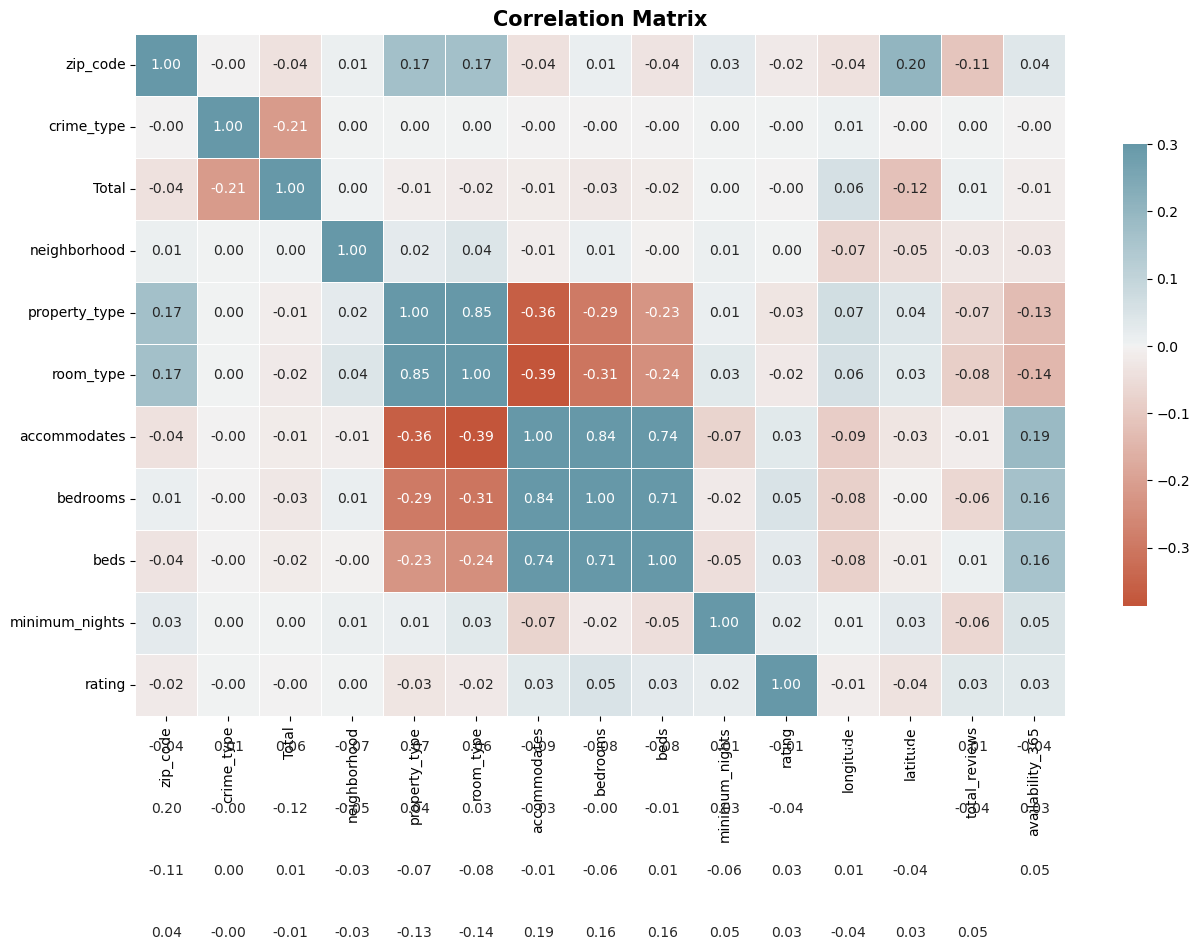

In [37]:
plt.figure(figsize=(15,12))
palette = sns.diverging_palette(20, 220, n=256)
corr=X.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(11, 0))
plt.title("Correlation Matrix",size=15, weight='bold')
plt.show()

In [54]:
scaler = StandardScaler()
data = scaler.fit_transform(X)

In [55]:
data
X1 = data[:500000]

### Hyperparameter tuning with Tree-Structured Parzen Estimator (TPE)

In [56]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Create a subsample for hyperparameter tuning
X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=0.2, random_state=42)

In [50]:
# Define the objective function to minimize (RMSE)
start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

def objective(params):
    model = xgb.XGBRegressor(**params)
    mse_scores = -cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    rmse = np.sqrt(np.mean(mse_scores))
    return rmse

# Define the search space for hyperparameters
space = {
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'n_estimators': hp.choice('n_estimators', range(100, 2000)),
    'subsample': hp.uniform('subsample', 0.3, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 2),
    'reg_lambda': hp.loguniform('reg_lambda', -5, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),  # New parameter
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),  # New parameter
    'min_child_weight': hp.choice('min_child_weight', range(1, 10)),  # New parameter
    'max_delta_step': hp.choice('max_delta_step', range(0, 10))  # New parameter
}

# Perform hyperparameter tuning using TPE with cross-validation on subsamples
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

elapsed_time = (time.time() - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

2023-06-25 15:44:35.300269
100%|██████████| 50/50 [59:36<00:00, 71.54s/trial, best loss: 78.35301191907594]   
Elapsed time: 59.62 minutes


**These are the best parameters obtained from the tuning.**<br>
Store them in a variable for later use.

In [64]:
best_params={'colsample_bylevel': 0.608975027750234, 
 'colsample_bytree': 0.6189415546847479, 
 'gamma': 0.9111113980021522, 
 'learning_rate': 0.21020208541843463, 
 'max_delta_step': 0, 
 'max_depth': 7, 
 'min_child_weight': 7, 
 'n_estimators': 1291, 
 'reg_alpha': 0.0980898484096793, 
 'reg_lambda': 6.914631338252542, 
 'subsample': 0.7563461577916571}

In [ ]:
# best_params = {'colsample_bylevel': 0.6361198094340449,
#  'colsample_bytree': 0.840925209680729,
#  'gamma': 0.880633045189329,
#  'learning_rate': 0.137575226573817,
#  'max_delta_step': 0,
#  'max_depth': 7,
#  'min_child_weight': 3,
#  'n_estimators': 1324,
#  'reg_alpha': 0.630214290994112,
#  'reg_lambda': 0.018403147767716618,
#  'subsample': 0.9323815577260643}

**Train the model.**

In [114]:
start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

# Train the final model on the entire dataset using the best hyperparameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train_full, y_train_full)

# Evaluate the final model on the test set
y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE on Test Set:", rmse)

elapsed_time = (time.time() - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

Started at:  13:50:43
RMSE on Test Set: 9.305651946169132
Elapsed time: 2.99 minutes


**Test on new data.** <br>
Perform label encoding and scale the test data before doing the prediction.

In [132]:
X_unused = data[500000:]
y_unused = combined.price[500000:]
print(X_unused.shape, y_unused.shape)

# Evaluate the final model on the test set
y_pred_xgb = final_model.predict(X_unused)
rmse = np.sqrt(mean_squared_error(y_unused, y_pred_xgb))

print("RMSE on Test Set:", rmse)

RMSE on Test Set: 8.991678208985121


### 2.2 Encoding the data with OneHotEncoder

In [80]:
X = combined.drop(['price','property_type'],axis=1)[:480000]
y = combined.price[:480000]
data = X
data.shape

(480000, 14)

In [87]:
categorical_columns = ['crime_type', 'neighborhood', 'room_type']

encoder = OneHotEncoder(handle_unknown='ignore')
encoded_data = encoder.fit_transform(data[categorical_columns])

# Get the column names for the encoded features
feature_names = encoder.get_feature_names_out(categorical_columns)

# Convert the encoded data to a pandas DataFrame with column names
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=feature_names)

encoded_df

,crime_type_Aggravated Assault,crime_type_Aggravated Robbery,crime_type_Assault By Contact,crime_type_Assault On Public Servant,crime_type_Assault With Injury,crime_type_Auto Theft,crime_type_Burglary Non Residence,crime_type_Burglary Of Residence,crime_type_Burglary Of Vehicle,crime_type_Counterfeiting,...,neighborhood_Woodlake Trails,neighborhood_Woods Of Brushy Creek,neighborhood_Woods Of Century Park,neighborhood_Wooten,neighborhood_Yacht Harbor,neighborhood_Zilker,neighborhood_Zona Centro,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
479996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
479997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
479998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [89]:
data.index=encoded_df.index
# # Concatenate the encoded DataFrame with the original dataset
data_encoded = pd.concat([data, encoded_df], axis=1)

# # Remove the original categorical columns from the encoded dataset
data_encoded.drop(columns=categorical_columns, inplace=True)

In [90]:
data_encoded

,zip_code,Total,accommodates,bedrooms,beds,minimum_nights,rating,longitude,latitude,total_reviews,...,neighborhood_Woodlake Trails,neighborhood_Woods Of Brushy Creek,neighborhood_Woods Of Century Park,neighborhood_Wooten,neighborhood_Yacht Harbor,neighborhood_Zilker,neighborhood_Zona Centro,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,78705,750,2,1,1,1,4.93,-97.74455,30.29606,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,78745,5091,2,1,1,2,4.88,-97.78810,30.21078,24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,78745,6148,6,3,4,2,4.76,-97.79572,30.20196,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,78753,4052,6,3,4,1,5.00,-97.68820,30.37647,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,78702,930,6,2,3,1,4.85,-97.69616,30.25993,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479995,78754,333,2,1,1,1,4.94,-97.65761,30.37703,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
479996,78741,523,3,1,2,1,3.75,-97.72474,30.23043,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
479997,78741,3691,1,1,1,3,5.00,-97.72471,30.22082,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
479998,78744,332,1,1,1,2,5.00,-97.73085,30.19887,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [104]:
scaler = StandardScaler()
data = scaler.fit_transform(data_encoded)

### Hyperparameter tuning with Tree-Structured Parzen Estimator (TPE)

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(data_encoded, y, test_size=0.2, random_state=42)

# Create a subsample for hyperparameter tuning
X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=0.2, random_state=42)

# Define the objective function to minimize (RMSE)
start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

def objective(params):
    model = xgb.XGBRegressor(**params)
    mse_scores = -cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    rmse = np.sqrt(np.mean(mse_scores))
    return rmse

# Define the search space for hyperparameters
space = {
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'n_estimators': hp.choice('n_estimators', range(100, 2000)),
    'subsample': hp.uniform('subsample', 0.3, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 2),
    'reg_lambda': hp.loguniform('reg_lambda', -5, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),  # New parameter
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),  # New parameter
    'min_child_weight': hp.choice('min_child_weight', range(1, 10)),  # New parameter
    'max_delta_step': hp.choice('max_delta_step', range(0, 10))  # New parameter
}

# Perform hyperparameter tuning using TPE with cross-validation on subsamples
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

elapsed_time = (time.time() - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

# Train the final model on the entire dataset using the best hyperparameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train_full, y_train_full)

# Evaluate the final model on the test set
y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE on Test Set:", rmse)

elapsed_time = (time.time() - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

X_unused = data[500000:]
y_unused = combined.price[500000:]
print(X_unused.shape, y_unused.shape)

# Evaluate the final model on the test set
y_pred_xgb = final_model.predict(X_unused)
rmse = np.sqrt(mean_squared_error(y_unused, y_pred_xgb))

print("RMSE on Test Set:", rmse)

**Train the model.**

In [105]:
X_train_full, X_test, y_train_full, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

# Train the final model on the entire dataset using the best hyperparameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train_full, y_train_full)

# Evaluate the final model on the test set
y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE on Test Set:", rmse)

elapsed_time = (time.time() - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

Started at:  16:03:34
RMSE on Test Set: 15.015645425218686
Elapsed time: 19.82 minutes


**Test on new data.**

In [107]:
X_unused = combined.drop(['property_type','price'],axis=1)[480000:]
y_unused = combined.price[480000:]

encoded_data1 = encoder.transform(X_unused[categorical_columns])

# Get the column names for the encoded features
feature_names1 = encoder.get_feature_names_out(categorical_columns)

# Convert the encoded data to a pandas DataFrame with column names
encoded_df1 = pd.DataFrame(encoded_data1.toarray(), columns=feature_names1)

X_unused.index=encoded_df1.index
# # Concatenate the encoded DataFrame with the original dataset
data_encoded1 = pd.concat([X_unused, encoded_df1], axis=1)

# # Remove the original categorical columns from the encoded dataset
data_encoded1.drop(columns=categorical_columns, inplace=True)

a = scaler.transform(data_encoded1)

# Evaluate the final model on the test set
y_pred_xgb = final_model.predict(a)
rmse = np.sqrt(mean_squared_error(y_unused, y_pred_xgb))

print("RMSE on Test Set:", rmse)

RMSE on Test Set: 15.182286652695746


RMSE score was better when label encoder was used. We'll go with the predicted results when the RMSE score was 8.99.<br>
Concat the predicted results to the test data and write a csv file for further evaluation.

In [65]:
columns=['actual','predicted']
result = pd.DataFrame({'actual':y_unused,'predicted':y_pred_xgb})
xgb = pd.concat([result,combined[50000:]],axis=1)

xgb = xgb.rename(columns={'Total':'crime_type_total'})
xgb.to_csv('data/xgb.csv',index=False)

## 3. LightGBM 

### 3.1 Testing the model with mix of categorical and numerical data.

Split the data into dependent and independent variables.

In [139]:
X = combined.drop(['price'],axis=1)
y = combined.price[:500000]
X.shape, y.shape

categorical_columns = ['crime_type', 'neighborhood', "property_type", 'room_type']

for col in categorical_columns:
    X[col] = X[col].astype('category')
    
X1 = X[:500000]

### Hyperparameter tuning with Tree-Structured Parzen Estimator (TPE)

In [108]:
# Step 1: Split the data into tuning subset and training subset
X_train_full, X_test, y_train_full, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

X_train_tune, X_train_final, y_train_tune, y_train_final = train_test_split(X_train_full, 
                                                                            y_train_full, test_size=0.2, random_state=42)

In [111]:
start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

# Step 2: Define the objective function for tuning
def objective(params):
    # Train and evaluate the model with given hyperparameters using cross-validation
    model = lgb.LGBMRegressor(
        boosting_type='gbdt',
        objective='regression',
        metric='rmse',
        verbose=-1,
        n_jobs=-1,
        bagging_fraction=params['bagging_fraction'],
        feature_fraction=params['feature_fraction'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves'],
        categorical_feature= categorical_columns  # Specify auto or list of indices for categorical features
    )

    scores = -cross_val_score(model, X_train_tune, y_train_tune, cv=5, scoring='neg_mean_squared_error')
    mse = np.mean(scores)
    return mse

# Step 3: Define an expanded search space for hyperparameters
space = {
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.6, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth': hp.choice('max_depth', range(6, 16)),
    'num_leaves': hp.choice('num_leaves', [63, 127, 255, 511, 1023, 2047])
}

# Step 4: Configure the TPE algorithm and run the optimization with increased iterations
tpe_algorithm = tpe.suggest
best = fmin(fn=objective, space=space, algo=tpe_algorithm, max_evals=200)

# Step 5: Retrieve the best hyperparameters
best_hyperparams = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1,
    'n_jobs': -1,
    'bagging_fraction': best['bagging_fraction'],
    'feature_fraction': best['feature_fraction'],
    'learning_rate': best['learning_rate'],
    'max_depth': best['max_depth'] + 6,  # Add 6 to adjust for the range shift
    'num_leaves': [63, 127, 255, 511, 1023, 2047][best['num_leaves']],
    'categorical_feature': categorical_columns  # Specify auto or list of indices for categorical features
}

elapsed_time = (time.time() - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

**These are the best parameters obtained from the tuning.**<br>
Store them in a variable for later use.

In [117]:
print('Best Parameters:',best)

Best Parameters: {'bagging_fraction': 0.8624112839056597, 'feature_fraction': 0.7694191650315978, 'learning_rate': 0.4899703843303902, 'max_depth': 8, 'num_leaves': 5}


In [147]:
best_params = {'bagging_fraction': 0.8624112839056597, 
               'feature_fraction': 0.7694191650315978, 
               'learning_rate': 0.4899703843303902, 
               'max_depth': 8, 
               'num_leaves': 5
              }

**Fit the model**

In [149]:
start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

# Step 6: Train the model on the entire dataset using the best hyperparameters
best_model_lgb = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    metric='rmse',
    verbose=-1,
    n_jobs=-1,
    categorical_feature=categorical_columns,
    **best_params
)
best_model_lgb.fit(X_train_full, y_train_full)

# Evaluate the final model on the test set
y_pred_lgbm = best_model_lgb.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

print("RMSE on Test Set:", rmse_lgbm)

elapsed_time = (time.time() - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

Started at:  16:48:39
[LightGBM] [Warning] feature_fraction is set=0.7694191650315978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7694191650315978
[LightGBM] [Warning] bagging_fraction is set=0.8624112839056597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8624112839056597
RMSE on Test Set: 213.58667402829673
Elapsed time: 0.01 minutes


**Prediction on new data.**

In [150]:
start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

X_test_lgbm = X[500000:]
y_test_lgbm = combined.price[500000:]

# Evaluate the final model on the test set
y_pred_lgbm = best_model_lgb.predict(X_test_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test_lgbm, y_pred_lgbm))

print("RMSE on Test Set:", rmse_lgbm)

elapsed_time = (time.time() - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))


Started at:  16:48:41
RMSE on Test Set: 220.06882526463806
Elapsed time: 0.00 minutes


### 3.2 Testing the model with data encoded by OneHotEncoder

In [165]:
X=combined.drop(['price'],axis=1)
y=combined.price[:500000]
X.shape, y.shape

m1 = LabelEncoder()
mapping = ['crime_type','neighborhood','property_type','room_type']
X[mapping] = X[mapping].apply(m1.fit_transform)

X

scaler = StandardScaler()
data = scaler.fit_transform(X)
X1 = data[:500000]

### Hyperparameter tuning with Tree-Structured Parzen Estimator (TPE)

In [166]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Step 1: Split the data into tuning subset and training subset
X_train_tune, X_train_final, y_train_tune, y_train_final = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

In [110]:
X_train_full, X_test, y_train_full, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

# Step 1: Split the data into tuning subset and training subset
X_train_tune, X_train_final, y_train_tune, y_train_final = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

# Step 2: Define the objective function for tuning
def objective(params):
    # Train and evaluate the model with given hyperparameters using cross-validation
    model = lgb.LGBMRegressor(
        boosting_type='gbdt',
        objective='regression',
        metric='rmse',
        verbose=-1,
        n_jobs=-1,
        bagging_fraction=params['bagging_fraction'],
        feature_fraction=params['feature_fraction'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves']
    )
     
    scores = -cross_val_score(model, X_train_tune, y_train_tune, cv=5, scoring='neg_mean_squared_error')
    mse = np.mean(scores)
    return mse

# Step 3: Define an expanded search space for hyperparameters
space = {
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.6, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth': hp.choice('max_depth', range(6, 16)),
    'num_leaves': hp.choice('num_leaves', [63, 127, 255, 511, 1023, 2047])
}

# Step 4: Configure the TPE algorithm and run the optimization with increased iterations
tpe_algorithm = tpe.suggest
best = fmin(fn=objective, space=space, algo=tpe_algorithm, max_evals=200)

# Step 5: Retrieve the best hyperparameters
best_hyperparams = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1,
    'n_jobs': -1,
    'bagging_fraction': best['bagging_fraction'],
    'feature_fraction': best['feature_fraction'],
    'learning_rate': best['learning_rate'],
    'max_depth': best['max_depth'] + 6,  # Add 6 to adjust for the range shift
    'num_leaves': [63, 127, 255, 511, 1023, 2047][best['num_leaves']]
}

print(best_hyperparams)
elapsed_time = (time.time() - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))


Started at:  16:46:05
[LightGBM] [Warning] feature_fraction is set=0.7108407337784937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7108407337784937
[LightGBM] [Warning] bagging_fraction is set=0.7602509984001967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602509984001967
[LightGBM] [Warning] feature_fraction is set=0.7108407337784937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7108407337784937
[LightGBM] [Warning] bagging_fraction is set=0.7602509984001967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602509984001967
[LightGBM] [Warning] feature_fraction is set=0.7108407337784937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7108407337784937
[LightGBM] [Warning] bagging_fraction is set=0.7602509984001967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7602509984001967
[LightGBM] [Warning] feature_fraction is set=0.7108407337784937, colsample_

[LightGBM] [Warning] feature_fraction is set=0.8950418964691877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8950418964691877
[LightGBM] [Warning] bagging_fraction is set=0.7279828065446265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279828065446265
[LightGBM] [Warning] feature_fraction is set=0.8950418964691877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8950418964691877
[LightGBM] [Warning] bagging_fraction is set=0.7279828065446265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279828065446265
[LightGBM] [Warning] feature_fraction is set=0.8950418964691877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8950418964691877
[LightGBM] [Warning] bagging_fraction is set=0.7279828065446265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7279828065446265
[LightGBM] [Warning] feature_fraction is set=0.8950418964691877, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.848610094394212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.848610094394212
[LightGBM] [Warning] bagging_fraction is set=0.8617712332117795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8617712332117795
[LightGBM] [Warning] feature_fraction is set=0.6579718985842596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579718985842596
[LightGBM] [Warning] bagging_fraction is set=0.7478627463753011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7478627463753011
[LightGBM] [Warning] feature_fraction is set=0.6579718985842596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579718985842596
[LightGBM] [Warning] bagging_fraction is set=0.7478627463753011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7478627463753011
[LightGBM] [Warning] feature_fraction is set=0.6579718985842596, colsample_bytree=1.0 will be ignor

[LightGBM] [Warning] bagging_fraction is set=0.8307612822032777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8307612822032777
[LightGBM] [Warning] feature_fraction is set=0.8171238506530135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8171238506530135
[LightGBM] [Warning] bagging_fraction is set=0.8307612822032777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8307612822032777
[LightGBM] [Warning] feature_fraction is set=0.7404842651699713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7404842651699713
[LightGBM] [Warning] bagging_fraction is set=0.7695308727336942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7695308727336942
[LightGBM] [Warning] feature_fraction is set=0.7404842651699713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7404842651699713
[LightGBM] [Warning] bagging_fraction is set=0.7695308727336942, subsample=1.0 will be ignored. C

[LightGBM] [Warning] feature_fraction is set=0.9423767450588723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9423767450588723
[LightGBM] [Warning] bagging_fraction is set=0.7470944242383161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7470944242383161
[LightGBM] [Warning] feature_fraction is set=0.9423767450588723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9423767450588723
[LightGBM] [Warning] bagging_fraction is set=0.7470944242383161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7470944242383161
[LightGBM] [Warning] feature_fraction is set=0.9423767450588723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9423767450588723
[LightGBM] [Warning] bagging_fraction is set=0.7470944242383161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7470944242383161
[LightGBM] [Warning] feature_fraction is set=0.9423767450588723, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] bagging_fraction is set=0.9346484060494812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9346484060494812
[LightGBM] [Warning] feature_fraction is set=0.7577194220378723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7577194220378723
[LightGBM] [Warning] bagging_fraction is set=0.9346484060494812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9346484060494812
[LightGBM] [Warning] feature_fraction is set=0.7577194220378723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7577194220378723
[LightGBM] [Warning] bagging_fraction is set=0.9346484060494812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9346484060494812
[LightGBM] [Warning] feature_fraction is set=0.7577194220378723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7577194220378723
[LightGBM] [Warning] bagging_fraction is set=0.9346484060494812, subsample=1.0 will be ignored. C

[LightGBM] [Warning] bagging_fraction is set=0.8966495622061191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8966495622061191
[LightGBM] [Warning] feature_fraction is set=0.9160350964526124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9160350964526124
[LightGBM] [Warning] bagging_fraction is set=0.705680197122556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.705680197122556
[LightGBM] [Warning] feature_fraction is set=0.9160350964526124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9160350964526124
[LightGBM] [Warning] bagging_fraction is set=0.705680197122556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.705680197122556
[LightGBM] [Warning] feature_fraction is set=0.9160350964526124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9160350964526124
[LightGBM] [Warning] bagging_fraction is set=0.705680197122556, subsample=1.0 will be ignored. Curren

[LightGBM] [Warning] feature_fraction is set=0.7764313521442999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7764313521442999
[LightGBM] [Warning] bagging_fraction is set=0.8515183253168839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8515183253168839
[LightGBM] [Warning] feature_fraction is set=0.7764313521442999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7764313521442999
[LightGBM] [Warning] bagging_fraction is set=0.8515183253168839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8515183253168839
[LightGBM] [Warning] feature_fraction is set=0.7764313521442999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7764313521442999
[LightGBM] [Warning] bagging_fraction is set=0.8515183253168839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8515183253168839
[LightGBM] [Warning] feature_fraction is set=0.7707700882371341, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.824558097889026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.824558097889026
[LightGBM] [Warning] bagging_fraction is set=0.8889230830562428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8889230830562428
[LightGBM] [Warning] feature_fraction is set=0.824558097889026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.824558097889026
[LightGBM] [Warning] bagging_fraction is set=0.8889230830562428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8889230830562428
[LightGBM] [Warning] feature_fraction is set=0.824558097889026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.824558097889026
[LightGBM] [Warning] bagging_fraction is set=0.8889230830562428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8889230830562428
[LightGBM] [Warning] feature_fraction is set=0.824558097889026, colsample_bytree=1.0 will be ignored. C

[LightGBM] [Warning] bagging_fraction is set=0.812538440818035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.812538440818035
[LightGBM] [Warning] feature_fraction is set=0.7857402196297509, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7857402196297509
[LightGBM] [Warning] bagging_fraction is set=0.812538440818035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.812538440818035
[LightGBM] [Warning] feature_fraction is set=0.7429621638139403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429621638139403
[LightGBM] [Warning] bagging_fraction is set=0.945642852494426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.945642852494426
[LightGBM] [Warning] feature_fraction is set=0.7429621638139403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7429621638139403
[LightGBM] [Warning] bagging_fraction is set=0.945642852494426, subsample=1.0 will be ignored. Current 

[LightGBM] [Warning] feature_fraction is set=0.8786257940761754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8786257940761754
[LightGBM] [Warning] bagging_fraction is set=0.6913643742316838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6913643742316838
[LightGBM] [Warning] feature_fraction is set=0.8786257940761754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8786257940761754
[LightGBM] [Warning] bagging_fraction is set=0.6913643742316838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6913643742316838
[LightGBM] [Warning] feature_fraction is set=0.8786257940761754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8786257940761754
[LightGBM] [Warning] bagging_fraction is set=0.6913643742316838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6913643742316838
[LightGBM] [Warning] feature_fraction is set=0.8786257940761754, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.6999133466228364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6999133466228364
[LightGBM] [Warning] bagging_fraction is set=0.7339149798050143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7339149798050143
[LightGBM] [Warning] feature_fraction is set=0.6999133466228364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6999133466228364
[LightGBM] [Warning] bagging_fraction is set=0.7339149798050143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7339149798050143
[LightGBM] [Warning] feature_fraction is set=0.6999133466228364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6999133466228364
[LightGBM] [Warning] bagging_fraction is set=0.7339149798050143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7339149798050143
[LightGBM] [Warning] feature_fraction is set=0.6999133466228364, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.7602548992596478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7602548992596478
[LightGBM] [Warning] bagging_fraction is set=0.6374602689452333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6374602689452333
[LightGBM] [Warning] feature_fraction is set=0.747628453313755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.747628453313755
[LightGBM] [Warning] bagging_fraction is set=0.7071346576856886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7071346576856886
[LightGBM] [Warning] feature_fraction is set=0.747628453313755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.747628453313755
[LightGBM] [Warning] bagging_fraction is set=0.7071346576856886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7071346576856886
[LightGBM] [Warning] feature_fraction is set=0.747628453313755, colsample_bytree=1.0 will be ignored.

[LightGBM] [Warning] bagging_fraction is set=0.6782528447403465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6782528447403465
[LightGBM] [Warning] feature_fraction is set=0.6347445827821827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6347445827821827
[LightGBM] [Warning] bagging_fraction is set=0.6782528447403465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6782528447403465
[LightGBM] [Warning] feature_fraction is set=0.6347445827821827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6347445827821827
[LightGBM] [Warning] bagging_fraction is set=0.6782528447403465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6782528447403465
[LightGBM] [Warning] feature_fraction is set=0.6347445827821827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6347445827821827
[LightGBM] [Warning] bagging_fraction is set=0.6782528447403465, subsample=1.0 will be ignored. C

[LightGBM] [Warning] feature_fraction is set=0.9054172727835542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9054172727835542
[LightGBM] [Warning] bagging_fraction is set=0.7736853573520929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7736853573520929
[LightGBM] [Warning] feature_fraction is set=0.6139659978852112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6139659978852112
[LightGBM] [Warning] bagging_fraction is set=0.8156580679757478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8156580679757478
[LightGBM] [Warning] feature_fraction is set=0.6139659978852112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6139659978852112
[LightGBM] [Warning] bagging_fraction is set=0.8156580679757478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8156580679757478
[LightGBM] [Warning] feature_fraction is set=0.6139659978852112, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] bagging_fraction is set=0.8244080917059162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8244080917059162
[LightGBM] [Warning] feature_fraction is set=0.7903148439505376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7903148439505376
[LightGBM] [Warning] bagging_fraction is set=0.8244080917059162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8244080917059162
[LightGBM] [Warning] feature_fraction is set=0.6956536097209213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6956536097209213
[LightGBM] [Warning] bagging_fraction is set=0.7424979876530624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7424979876530624
[LightGBM] [Warning] feature_fraction is set=0.6956536097209213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6956536097209213
[LightGBM] [Warning] bagging_fraction is set=0.7424979876530624, subsample=1.0 will be ignored. C

[LightGBM] [Warning] bagging_fraction is set=0.7307922765578607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7307922765578607
[LightGBM] [Warning] feature_fraction is set=0.6501426829979253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6501426829979253
[LightGBM] [Warning] bagging_fraction is set=0.7307922765578607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7307922765578607
[LightGBM] [Warning] feature_fraction is set=0.6501426829979253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6501426829979253
[LightGBM] [Warning] bagging_fraction is set=0.7307922765578607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7307922765578607
[LightGBM] [Warning] feature_fraction is set=0.662594527916629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.662594527916629
[LightGBM] [Warning] bagging_fraction is set=0.7692256564119664, subsample=1.0 will be ignored. Cur

[LightGBM] [Warning] feature_fraction is set=0.7927537214999316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7927537214999316
[LightGBM] [Warning] bagging_fraction is set=0.7509275934506846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509275934506846
[LightGBM] [Warning] feature_fraction is set=0.7927537214999316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7927537214999316
[LightGBM] [Warning] bagging_fraction is set=0.7509275934506846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509275934506846
[LightGBM] [Warning] feature_fraction is set=0.7927537214999316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7927537214999316
[LightGBM] [Warning] bagging_fraction is set=0.7509275934506846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509275934506846
[LightGBM] [Warning] feature_fraction is set=0.8243872052726336, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.9223686169238794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9223686169238794
[LightGBM] [Warning] bagging_fraction is set=0.6206560913061303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6206560913061303
[LightGBM] [Warning] feature_fraction is set=0.9223686169238794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9223686169238794
[LightGBM] [Warning] bagging_fraction is set=0.6206560913061303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6206560913061303
[LightGBM] [Warning] feature_fraction is set=0.9223686169238794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9223686169238794
[LightGBM] [Warning] bagging_fraction is set=0.6206560913061303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6206560913061303
[LightGBM] [Warning] feature_fraction is set=0.9223686169238794, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.9464238229665531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9464238229665531
[LightGBM] [Warning] bagging_fraction is set=0.6386871491255142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6386871491255142
[LightGBM] [Warning] feature_fraction is set=0.9464238229665531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9464238229665531
[LightGBM] [Warning] bagging_fraction is set=0.6386871491255142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6386871491255142
[LightGBM] [Warning] feature_fraction is set=0.9464238229665531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9464238229665531
[LightGBM] [Warning] bagging_fraction is set=0.6386871491255142, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6386871491255142
[LightGBM] [Warning] feature_fraction is set=0.9464238229665531, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] bagging_fraction is set=0.6219633130570638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6219633130570638
[LightGBM] [Warning] feature_fraction is set=0.900292123891831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900292123891831
[LightGBM] [Warning] bagging_fraction is set=0.6219633130570638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6219633130570638
[LightGBM] [Warning] feature_fraction is set=0.900292123891831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900292123891831
[LightGBM] [Warning] bagging_fraction is set=0.6219633130570638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6219633130570638
[LightGBM] [Warning] feature_fraction is set=0.9542745034718624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9542745034718624
[LightGBM] [Warning] bagging_fraction is set=0.6306621575996824, subsample=1.0 will be ignored. Curre

[LightGBM] [Warning] feature_fraction is set=0.9901859265749087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9901859265749087
[LightGBM] [Warning] bagging_fraction is set=0.6742239981387914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6742239981387914
[LightGBM] [Warning] feature_fraction is set=0.9901859265749087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9901859265749087
[LightGBM] [Warning] bagging_fraction is set=0.6742239981387914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6742239981387914
[LightGBM] [Warning] feature_fraction is set=0.9901859265749087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9901859265749087
[LightGBM] [Warning] bagging_fraction is set=0.6742239981387914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6742239981387914
[LightGBM] [Warning] feature_fraction is set=0.9901859265749087, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.8703003394697768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8703003394697768
[LightGBM] [Warning] bagging_fraction is set=0.6206751043558069, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6206751043558069
[LightGBM] [Warning] feature_fraction is set=0.985070414059664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.985070414059664
[LightGBM] [Warning] bagging_fraction is set=0.6478025487942449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6478025487942449
[LightGBM] [Warning] feature_fraction is set=0.985070414059664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.985070414059664
[LightGBM] [Warning] bagging_fraction is set=0.6478025487942449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6478025487942449
[LightGBM] [Warning] feature_fraction is set=0.985070414059664, colsample_bytree=1.0 will be ignored.

**These are the best parameters.**

In [112]:
print('Best Parameters: ',best)

Best Parameters:  {'bagging_fraction': 0.6731999575318383, 'feature_fraction': 0.7262807278901487, 'learning_rate': 0.49865772814883014, 'max_depth': 9, 'num_leaves': 5}


In [113]:
# best_params = {'bagging_fraction': 0.7084339843897957, 
#                'feature_fraction': 0.90633915221954, 
#                'learning_rate': 0.49745606089624805, 
#                'max_depth': 9, 
#                'num_leaves': 4}

best_params = {'bagging_fraction': 0.6731999575318383, 
                   'feature_fraction': 0.7262807278901487, 
                   'learning_rate': 0.49865772814883014, 
                   'max_depth': 9, 
                   'num_leaves': 5}

**Fit the model.**

In [114]:
# Step 6: Train the model on the entire dataset using the best hyperparameters
best_model_lgb = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    metric='rmse',
    verbose=-1,
    n_jobs=-1,
    **best_params
)
best_model_lgb.fit(X_train_full, y_train_full)

# Evaluate the final model on the test set
y_pred_lgbm = best_model_lgb.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

print("RMSE on Test Set:", rmse_lgbm)

[LightGBM] [Warning] feature_fraction is set=0.7262807278901487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7262807278901487
[LightGBM] [Warning] bagging_fraction is set=0.6731999575318383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6731999575318383
RMSE on Test Set: 80.29228791194778


**Test on new data**

In [115]:
X_unused = combined.drop(['property_type','price'],axis=1)[480000:]
y_unused = combined.price[480000:]

encoded_data1 = encoder.transform(X_unused[categorical_columns])

# Get the column names for the encoded features
feature_names1 = encoder.get_feature_names_out(categorical_columns)

# Convert the encoded data to a pandas DataFrame with column names
encoded_df1 = pd.DataFrame(encoded_data1.toarray(), columns=feature_names1)

X_unused.index=encoded_df1.index
# # Concatenate the encoded DataFrame with the original dataset
data_encoded1 = pd.concat([X_unused, encoded_df1], axis=1)

# # Remove the original categorical columns from the encoded dataset
data_encoded1.drop(columns=categorical_columns, inplace=True)

a = scaler.transform(data_encoded1)

# Evaluate the final model on the test set
y_pred_xgb = best_model_lgb.predict(a)
rmse = np.sqrt(mean_squared_error(y_unused, y_pred_xgb))

print("RMSE on Test Set:", rmse)

RMSE on Test Set: 80.95285743814127


### Analyze the predicted result.

Table below shows the RMSE scores of each model when fed with seen data and unseen data.

In [53]:
data = [{'CatBoost':16.66, 'XGBoost':9.31, 'LightGBM':80.29}, {'CatBoost':14.48, 'XGBoost':8.99, 'LightGBM':80.95}]

rmse = pd.DataFrame(data,index=['Training','Testing'])
rmse

,CatBoost,XGBoost,LightGBM
Training,16.66,9.31,80.29
Testing,14.48,8.99,80.95


Since, the rmse score of XGBoost is low compared to rest of the algorithms, let's go with XGBoost.

In [3]:
xgb = pd.read_csv('data/xgb.csv')

In [76]:
xgb.head()

,actual,predicted,zip_code,crime_type,crime_type_total,neighborhood,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,rating,price,longitude,latitude,total_reviews,availability_365
0,216,171.217910,78734,Criminal Mischief,2,Highland Club Village,Private room in bed and breakfast,Private room,3,1,1,1,4.98,216,-97.918970,30.394870,46,270
1,81,86.571090,78704,Driving While Intox / Felony,354,South Lamar,Entire rental unit,Entire home/apt,2,1,1,2,5.00,81,-97.785995,30.239824,4,48
2,443,444.952600,78701,Harassment,1677,Downtown Austin,Entire condo,Entire home/apt,2,1,2,1,4.38,443,-97.740840,30.264930,64,312
3,75,80.693954,78741,DWI,6849,Parker Lane,Entire rental unit,Entire home/apt,3,1,1,2,4.86,75,-97.745340,30.226030,8,0
4,325,320.928500,78741,Theft,16528,East Riverside - Oltorf,Entire home,Entire home/apt,8,5,4,30,5.00,325,-97.736610,30.233780,1,99


In [4]:
per = (xgb.actual-xgb.predicted)/xgb.actual *100
x = pd.DataFrame({'percent_change':per})
percent = pd.concat([x,xgb],axis=1)

In [5]:
percent.head()

,percent_change,actual,predicted,zip_code,crime_type,crime_type_total,neighborhood,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,rating,price,longitude,latitude,total_reviews,availability_365
0,20.732449,216,171.217910,78734,Criminal Mischief,2,Highland Club Village,Private room in bed and breakfast,Private room,3,1,1,1,4.98,216,-97.918970,30.394870,46,270
1,-6.877889,81,86.571090,78704,Driving While Intox / Felony,354,South Lamar,Entire rental unit,Entire home/apt,2,1,1,2,5.00,81,-97.785995,30.239824,4,48
2,-0.440767,443,444.952600,78701,Harassment,1677,Downtown Austin,Entire condo,Entire home/apt,2,1,2,1,4.38,443,-97.740840,30.264930,64,312
3,-7.591939,75,80.693954,78741,DWI,6849,Parker Lane,Entire rental unit,Entire home/apt,3,1,1,2,4.86,75,-97.745340,30.226030,8,0
4,1.252769,325,320.928500,78741,Theft,16528,East Riverside - Oltorf,Entire home,Entire home/apt,8,5,4,30,5.00,325,-97.736610,30.233780,1,99


In [6]:
percent[['actual','predicted']].describe()

,actual,predicted
count,38829.000000,38829.000000
mean,294.557805,294.605425
std,462.077580,460.633444
min,1.000000,-2.172894
25%,105.000000,107.500730
50%,178.000000,178.482770
75%,311.000000,311.064150
max,10450.000000,10557.747000


We'll look at the positive percent change since positive change means the actual prices were supposed to be lower.<br>
Also, the model predicted few negative prices too. Lets remove them.

In [7]:
pos_per = percent[percent.predicted>0]

In [8]:
pos_per.sort_values(by='percent_change',ascending=True)

,percent_change,actual,predicted,zip_code,crime_type,crime_type_total,neighborhood,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,rating,price,longitude,latitude,total_reviews,availability_365
2305,-174.955767,30,82.486730,78704,Burglary Of Vehicle,17912,Galindo,Entire rental unit,Entire home/apt,2,1,1,1,4.93,30,-97.76656,30.231430,0,0
35090,-153.727367,30,76.118210,78704,Forgery - Other,154,Galindo,Entire rental unit,Entire home/apt,2,1,1,1,4.93,30,-97.76656,30.231430,0,0
4286,-153.628200,30,76.088460,78704,Fraud - Other,1277,Galindo,Entire rental unit,Entire home/apt,2,1,1,1,4.93,30,-97.76656,30.231430,0,0
12692,-153.149867,30,75.944960,78704,Debit/Credit Card Abuse,1763,Galindo,Entire rental unit,Entire home/apt,2,1,1,1,4.93,30,-97.76656,30.231430,0,0
32677,-152.844500,30,75.853350,78704,Identity Theft,1495,Galindo,Entire rental unit,Entire home/apt,2,1,1,1,4.93,30,-97.76656,30.231430,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14842,61.614190,100,38.385810,78734,Violation City Ordinance,4,Villas On Travis,Entire rental unit,Entire home/apt,4,2,1,30,4.93,100,-97.93785,30.391956,0,365
6376,61.950997,62,23.590382,78730,Family Disturbance,347,Riverplace,Private room in home,Private room,2,1,1,5,4.93,62,-97.85001,30.385640,0,350
583,65.336544,50,17.331728,78730,Assault With Injury,166,Riverplace,Private room in home,Private room,2,1,1,5,4.93,50,-97.85066,30.387110,0,357
32507,65.743773,62,21.238861,78730,Theft,319,Riverplace,Private room in home,Private room,2,1,1,5,4.93,62,-97.85001,30.385640,0,350


In [9]:
pos_per = pos_per[pos_per.predicted<pos_per.actual].sort_values(by='percent_change')

Drop the rows where the percent change is very negligible.

In [10]:
pos_per = pos_per[pos_per.percent_change>0.1]

In [11]:
pos_per.head()

,percent_change,actual,predicted,zip_code,crime_type,crime_type_total,neighborhood,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,rating,price,longitude,latitude,total_reviews,availability_365
11894,0.100187,75,74.92486,78749,Unlawful Carrying Weapon,47,Circle C,Camper/RV,Entire home/apt,2,1,1,1,4.94,75,-97.850530,30.215310,589,64
2004,0.100250,100,99.89975,78728,Deadly Conduct,3,Northridge Acres,Private room in home,Private room,2,1,1,1,1.00,100,-97.680016,30.469503,1,365
10488,0.100280,9998,9987.97400,78750,Fraud - Other,429,Long Canyon,Private room in condo,Private room,2,1,1,5,4.67,9998,-97.777600,30.436300,3,179
10693,0.100349,502,501.49625,78702,Theft Of Trailer,109,Point Breeze,Entire home,Entire home/apt,8,3,4,3,5.00,502,-97.721660,30.253030,27,15
13777,0.100480,250,249.74880,78702,Driving While Intox / Felony,271,East Downtown,Private room in home,Private room,1,1,1,1,5.00,250,-97.730050,30.260260,5,3


In [12]:
#Chang the formatting to two decimal places.
col = ['percent_change','predicted']
for x in col:
    pos_per[x] = pos_per[x].apply(lambda x: round(x, 2))

In [14]:
#calculate the total sum of the actual price and predicted price
total_sum = pos_per.groupby('zip_code').agg(actual_sum=('actual','sum'),predicted_sum=('predicted','sum')).reset_index()

#calculate the change in percentage of actual and predicted price
percent = (total_sum.actual_sum-total_sum.predicted_sum)/total_sum.actual_sum *100

#create a dataframe for percent column
percent_df = pd.DataFrame({'overall_diff':percent})

#merge the columns into a new dataframe
df1 = pd.concat([total_sum, percent_df],axis=1)

#calculate total number of listings in each zip
bnb = pd.read_csv('data/airbnb_formatted.csv')
listing = bnb.groupby('zip_code').agg(listing_count=('zip_code','count')).reset_index()

#calculate the total crimes from the original data file
crime_count = crime.groupby('zip_code').agg(total_crime_count=('crime_type','count')).reset_index().sort_values(by='total_crime_count',ascending=False)

#merge all the columns and dataframe created in earlier steps
df = pd.merge(df1, crime_count, how='inner',on='zip_code').merge(listing,how='inner',on='zip_code')

In [16]:
df.sort_values(by='overall_diff',ascending=False).head(5)

,zip_code,actual_sum,predicted_sum,overall_diff,total_crime_count,listing_count
21,78734,21832,20687.04,5.244412,16,334
13,78726,5226,5035.75,3.640452,12063,16
35,78751,125524,121027.72,3.582008,64423,497
36,78752,56092,54232.20,3.315624,87029,242
6,78717,15233,14808.97,2.783628,14022,64


In [171]:
df.sort_values(by='overall_diff',ascending=False).tail(5)

,zip_code,actual_sum,predicted_sum,overall_diff,total_crime_count,listing_count
34,78750,47866,47413.14,0.946100,25522,91
20,78733,38568,38209.48,0.929579,188,87
24,78737,62675,62120.46,0.884787,223,172
30,78746,252067,249928.80,0.848267,29461,285
19,78732,57911,57427.42,0.835040,345,76


In spite with the crime count of 16 the percentage difference is the highest in zip 78734.<br>
Let's dive more into this zip code.

Price predicted for 78734 by the model.

In [17]:
pos_per[pos_per.zip_code==78734][['actual','predicted']].sort_values(by='predicted')

,actual,predicted
36063,39,6.13
17177,50,36.01
14842,100,38.39
27534,72,48.30
22711,72,52.76
38058,96,77.10
23139,81,80.14
17443,100,81.85
26842,100,93.34
3462,105,97.64


Some of the predicted prices are one third or half of the actual prices which is a drastic drop. Inaccurate predictions could be the result of training the model with insufficient data.<br><br>
Check the training data to gain insight on what proportion of data was related to zip 78734. But before we do that, let's reverse the scaling that was performed on the data.

In [172]:
#use the same scalar that was used to scale the training/testing data earlier
rev = scaler.inverse_transform(X_train_full)
rev_ = pd.DataFrame(rev)

#get the column names from the dataframe X
rev_.columns = X.columns

print("Total rows in training data:", len(X_train_full))
rev_[rev_.zip_code==78734]['zip_code'].value_counts()

Total rows in training data: 400000


78734.0    978
Name: zip_code, dtype: int64

Out of 400,000 rows, only 978 were related to zip 78734. This clarifies the model's poor performance on the prediction for zip 78734 as the data was not sufficient enough.

Let's look at the data.

In [150]:
df.sort_values(by='overall_diff',ascending=False)

,zip_code,actual_sum,predicted_sum,overall_diff,total_crime_count,listing_count
21,78734,21832,20687.04,5.244412,16,334
13,78726,5226,5035.75,3.640452,12063,16
35,78751,125524,121027.72,3.582008,64423,497
36,78752,56092,54232.20,3.315624,87029,242
6,78717,15233,14808.97,2.783628,14022,64
5,78712,1000,973.35,2.665000,1242,2
4,78705,214974,209332.90,2.624085,56693,558
26,78741,315765,307624.26,2.578101,209732,916
9,78722,85455,83281.86,2.543023,20267,248
15,78728,24867,24235.37,2.540033,890,121


In [151]:
df[(df.total_crime_count>4000) & (df.overall_diff>2)].sort_values(by='overall_diff',ascending=False)

,zip_code,actual_sum,predicted_sum,overall_diff,total_crime_count,listing_count
13,78726,5226,5035.75,3.640452,12063,16
35,78751,125524,121027.72,3.582008,64423,497
36,78752,56092,54232.20,3.315624,87029,242
6,78717,15233,14808.97,2.783628,14022,64
4,78705,214974,209332.90,2.624085,56693,558
26,78741,315765,307624.26,2.578101,209732,916
9,78722,85455,83281.86,2.543023,20267,248
41,78758,117185,114415.89,2.363024,162966,415
37,78753,39669,38741.50,2.338098,179335,183
40,78757,80009,78162.40,2.307990,54629,257


Looking at the data, it seems like places with high crimes have around 2% to 3% price drop suggestion. Let's get the accurate rate.

In [252]:
get_percent = pos_per[pos_per.percent_change>=1]
math.ceil(get_percent.percent_change.mean())

4

### The model suggests price drop upto 4% based on the ongoing crimes in each location.

### Visual representation of predicted and actual price per zip location

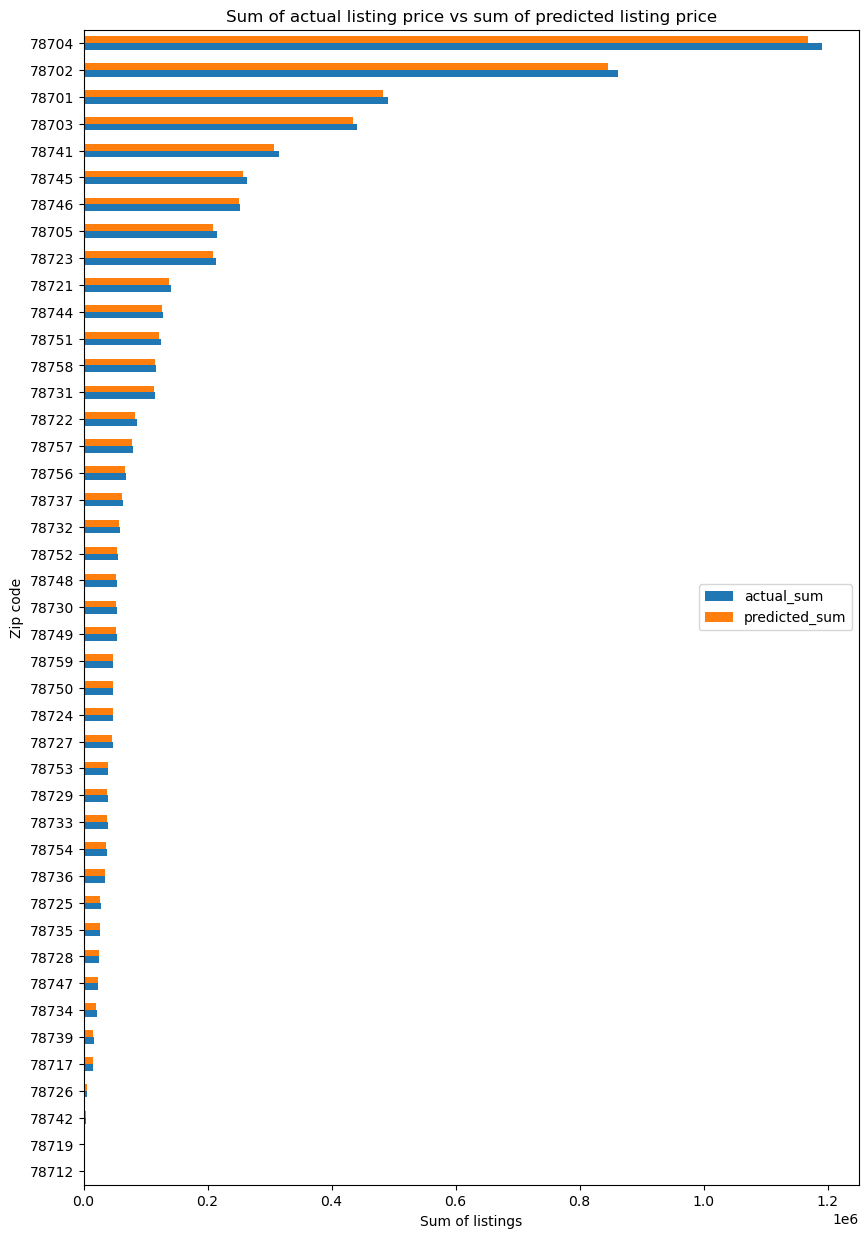

In [19]:
total_sum.set_index('zip_code').sort_values(by='actual_sum',ascending=True).plot(kind='barh', figsize=(10, 15))
plt.legend(loc="center right")
plt.xlabel("Sum of listings")
plt.ylabel("Zip code")
plt.title('Sum of actual listing price vs sum of predicted listing price')
plt.show()

**Safe locations to stay**

In [246]:
d = df[['total_crime_count','zip_code']].sort_values(by='total_crime_count')
h = d.head(10)
t = d.tail(10).sort_values(by='total_crime_count',ascending=False)

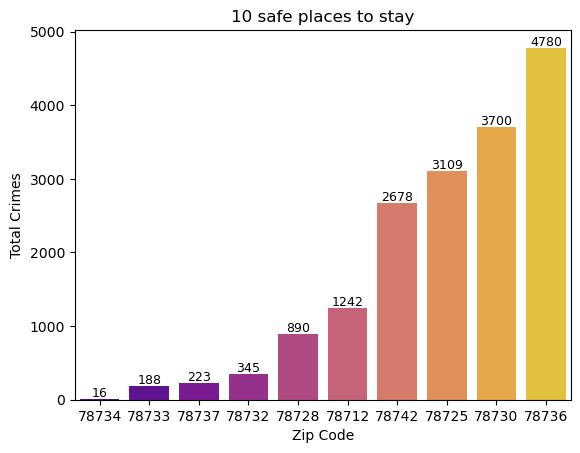

In [97]:
ax = sns.barplot(data=h, x='zip_code', y ='total_crime_count', order=h.sort_values("total_crime_count").zip_code, palette="plasma")
ax.set(ylabel="Total Crimes", xlabel="Zip Code", title='10 safe places to stay')

for i, v in enumerate(h.total_crime_count):
    ax.text(i, v + 30, str(v), ha='center', fontsize=9)

**Unsafe locations to avoid**

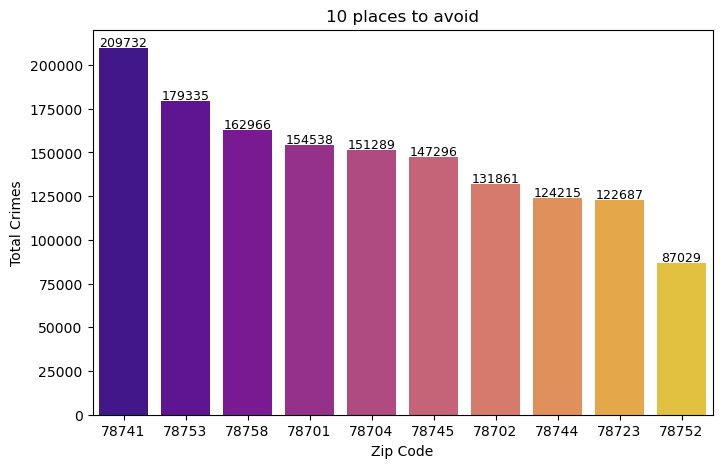

In [155]:
plt.figure(figsize=(8,5))
ax = sns.barplot(data=t, x='zip_code', y ='total_crime_count', order=t.sort_values("total_crime_count",ascending=False).zip_code, palette="plasma")
ax.set(ylabel="Total Crimes", xlabel="Zip Code", title='10 places to avoid')

for i, v in enumerate(t.total_crime_count):
    ax.text(i, v + 800, str(v), ha='center', fontsize=9)

**Average listing price in each zip**<br>First, remove the outliers to get accurate results.

In [165]:
quant = bnb.price.quantile([0.25,0.75])
q1, q3 = quant[0.25], quant[0.75]
print(q1,q3)
IQR = q3-q1
low  = q1-1.5*IQR
high = q3+1.5*IQR
print(low,high)

107.0 320.0
-212.5 639.5


In [166]:
#filter the values which are higher than the upper quartile
avg_price = pos_per[pos_per.actual<=high]

#calculate the mean price for each zip code
avg = avg_price.groupby('zip_code').agg(Average_price = ('price','mean')).reset_index().sort_values(by='Average_price')

#to plot the bar in the same order as above(bar plot of zip's with low and high crime rate), allign the zip codes for xticks
h_avg = avg[avg.zip_code.isin(h.zip_code)]
t_avg = avg[avg.zip_code.isin(t.zip_code)]

**Average price of listings per zip code. The xticks are matched with the bar plot above.**

**Average prices of safe locations**

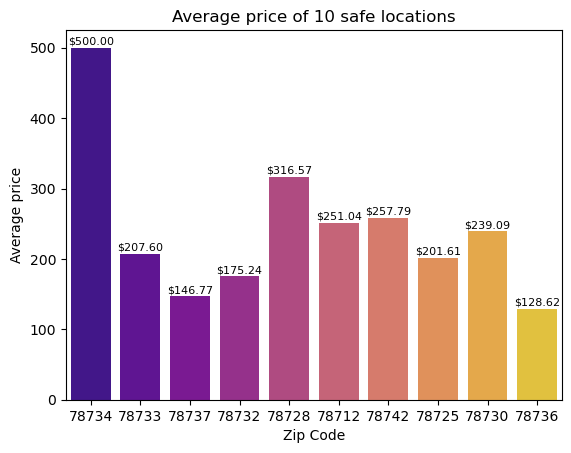

In [254]:
ax = sns.barplot(data=h_avg, x='zip_code', y='Average_price', palette="plasma")
ax.set(ylabel="Average price", xlabel="Zip Code", title='Average price of 10 safe locations')
plt.xticks(range(len(h.zip_code.tolist())), h.zip_code.tolist())

for bar in ax.patches:
    x_coord = bar.get_x() + bar.get_width() / 2  # Get the x-coordinate of the bar center
    height = bar.get_height()  # Get the height of the bar
    ax.text(x_coord, height + 5, "${:.2f}".format(round(height, 2)), ha='center', fontsize=8)

plt.show()

**Average prices of unsafe locations**

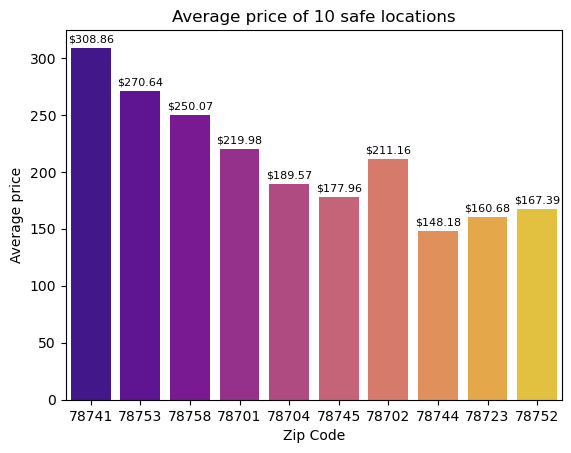

In [256]:
ax = sns.barplot(data=t_avg, x='zip_code', y='Average_price', palette="plasma")
ax.set(ylabel="Average price", xlabel="Zip Code", title='Average price of 10 safe locations')
plt.xticks(range(len(t.zip_code.tolist())), t.zip_code.tolist())

for bar in ax.patches:
    x_coord = bar.get_x() + bar.get_width() / 2  # Get the x-coordinate of the bar center
    height = bar.get_height()  # Get the height of the bar
    ax.text(x_coord, height + 5, "${:.2f}".format(round(height, 2)), ha='center', fontsize=8)

plt.show()